# Analyzing the effect of proposed homeless sleeping limits in Los Angeles

By [Matt Stiles](https://www.latimes.com/la-bio-matt-stiles-staff.html) and [Ryan Menezes](https://www.latimes.com/staff/ryan-menezes)

This notebook documents the process of examining the effects of proposed sleeping restriction on the homeless population in Los Angeles. The proposed city rules would limit sleeping in 500-foot buffer zones around selected property types, including schools, parks and childcare facilities, among others. This analysis draws those buffer zones around the properties, which are identified in government mapping data, and calculates the area included in the limits citywide and by neighborhood.  

### Load libraries

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pandas import DataFrame
%matplotlib inline

### Read raw data from city, county GIS portals

In [2]:
rawfiles = {
    # childcare spatial file uses points to avoid assigning single-location facilities to multi-location parcels
    # bikeways not included because they don't need to be buffered
    # 'bikeways': 'raw/la_city_bikeways.geojson',
    # homeless shelters excluded until recent locations file acquired
    #'homeless': 'raw/la_county_gis_homeless_shelters_1566703407847.geojson',
    'childcare': 'raw/la_city_gis_childcare_clipped.geojson',
    'parks': 'raw/la_city_county_parks.geojson',
    'public_schools': 'raw/lausd_schools_boundaries_1566703408821.geojson',
    'private_schools': 'raw/la_county_private_school_parcels.geojson',
    'special_venues': 'raw/la_city_special_venues.geojson'
}

### Reproject spatial data for distance calculations

In [3]:
def reproject(i, o, c = 3310):
    return f'ogr2ogr processed/{o}_{c}.geojson -t_srs "EPSG:3310" {i}'

In [4]:
for r in rawfiles:
    s = reproject(rawfiles[r], r)
    print(s)
    !$s

ogr2ogr processed/childcare_3310.geojson -t_srs "EPSG:3310" raw/la_city_gis_childcare_clipped.geojson
ogr2ogr processed/parks_3310.geojson -t_srs "EPSG:3310" raw/la_city_county_parks.geojson
ogr2ogr processed/public_schools_3310.geojson -t_srs "EPSG:3310" raw/lausd_schools_boundaries_1566703408821.geojson
ogr2ogr processed/private_schools_3310.geojson -t_srs "EPSG:3310" raw/la_county_private_school_parcels.geojson
ogr2ogr processed/special_venues_3310.geojson -t_srs "EPSG:3310" raw/la_city_special_venues.geojson


### Dataframes from city, county spatial files

In [5]:
alldata = pd.concat([gpd.read_file(f'processed/{r}_3310.geojson') for r in rawfiles])[['geometry']]

/Users/mhustiles/.virtualenvs/twitter/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [6]:
alldata.crs

{'init': 'epsg:3310'}

In [7]:
alldata.head()

,geometry
0,(POINT (163813.8930618464 -439249.2645478053))
1,(POINT (163606.8981438576 -439216.8566115182))
2,(POINT (162089.5895063573 -439290.9106377037))
3,(POINT (159980.3012114689 -443436.5564146922))
4,(POINT (159887.4485011428 -436884.1232245923))


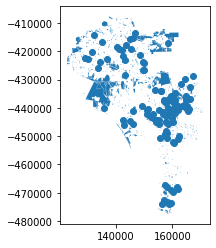

In [8]:
alldata.plot()

In [9]:
alldata['buffer'] = alldata.buffer(152.4)

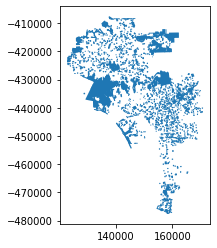

In [10]:
gpd.GeoSeries(alldata['buffer']).plot()

In [11]:
alldata['dummy'] = 'abc'

In [12]:
alldata.head()

,geometry,buffer,dummy
0,(POINT (163813.8930618464 -439249.2645478053)),POLYGON ((163966.2930618464 -439249.2645478053...,abc
1,(POINT (163606.8981438576 -439216.8566115182)),POLYGON ((163759.2981438576 -439216.8566115182...,abc
2,(POINT (162089.5895063573 -439290.9106377037)),POLYGON ((162241.9895063573 -439290.9106377037...,abc
3,(POINT (159980.3012114689 -443436.5564146922)),POLYGON ((160132.7012114689 -443436.5564146922...,abc
4,(POINT (159887.4485011428 -436884.1232245923)),POLYGON ((160039.8485011428 -436884.1232245923...,abc


In [13]:
allbuffers = gpd.GeoDataFrame(alldata[['dummy','buffer']], geometry='buffer').dissolve(by = 'dummy')

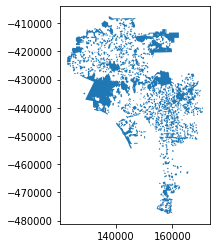

In [14]:
allbuffers.plot()

In [15]:
allbuffers.to_file('buffered/combined-buffers.geojson', driver='GeoJSON')

In [16]:
allbuffers.crs

In [17]:
allbuffers.geometry.area  / 2590000

dummy
abc    216.858108
dtype: float64

In [18]:
hoods = gpd.read_file('raw/la-county-neighborhoods-current.geojson')

In [19]:
hoods['hood_type'] = hoods['metadata'].apply(dict).apply(lambda x: x['type'])

In [20]:
hoods.to_crs({'init': 'epsg:3310'}, inplace=True)

In [21]:
hoods.head()

,kind,external_id,name,slug,set,metadata,resource_uri,geometry,hood_type
0,L.A. County Neighborhood (Current),acton,Acton,acton-la-county-neighborhood-current,/1.0/boundary-set/la-county-neighborhoods-curr...,"{'sqmi': 39.3391089485, 'type': 'unincorporate...",/1.0/boundary/acton-la-county-neighborhood-cur...,(POLYGON ((164907.1721133307 -384800.650005886...,unincorporated-area
1,L.A. County Neighborhood (Current),adams-normandie,Adams-Normandie,adams-normandie-la-county-neighborhood-current,/1.0/boundary-set/la-county-neighborhoods-curr...,"{'sqmi': 0.805350187789, 'type': 'segment-of-a...",/1.0/boundary/adams-normandie-la-county-neighb...,(POLYGON ((156139.6401248095 -440624.691527145...,segment-of-a-city
2,L.A. County Neighborhood (Current),agoura-hills,Agoura Hills,agoura-hills-la-county-neighborhood-current,/1.0/boundary-set/la-county-neighborhoods-curr...,"{'sqmi': 8.14676029818, 'type': 'standalone-ci...",/1.0/boundary/agoura-hills-la-county-neighborh...,(POLYGON ((114132.3855756644 -426762.559576650...,standalone-city
3,L.A. County Neighborhood (Current),agua-dulce,Agua Dulce,agua-dulce-la-county-neighborhood-current,/1.0/boundary-set/la-county-neighborhoods-curr...,"{'sqmi': 31.4626319451, 'type': 'unincorporate...",/1.0/boundary/agua-dulce-la-county-neighborhoo...,(POLYGON ((160091.8405679099 -382746.646477827...,unincorporated-area
4,L.A. County Neighborhood (Current),alhambra,Alhambra,alhambra-la-county-neighborhood-current,/1.0/boundary-set/la-county-neighborhoods-curr...,"{'sqmi': 7.62381430605, 'type': 'standalone-ci...",/1.0/boundary/alhambra-la-county-neighborhood-...,(POLYGON ((173279.8293033192 -432798.533470016...,standalone-city


In [22]:
lahoods = hoods.loc[hoods.hood_type == 'segment-of-a-city', ['name', 'geometry']]

In [23]:
lahoods.head()

,name,geometry
1,Adams-Normandie,(POLYGON ((156139.6401248095 -440624.691527145...
9,Arleta,(POLYGON ((145361.3096072993 -420096.183241406...
10,Arlington Heights,(POLYGON ((155472.5469032949 -438950.195603739...
13,Atwater Village,(POLYGON ((158739.6492951899 -427752.278756475...
17,Baldwin Hills/Crenshaw,(POLYGON ((151801.1076706515 -442096.112350080...


In [24]:
lahoods.head()

,name,geometry
1,Adams-Normandie,(POLYGON ((156139.6401248095 -440624.691527145...
9,Arleta,(POLYGON ((145361.3096072993 -420096.183241406...
10,Arlington Heights,(POLYGON ((155472.5469032949 -438950.195603739...
13,Atwater Village,(POLYGON ((158739.6492951899 -427752.278756475...
17,Baldwin Hills/Crenshaw,(POLYGON ((151801.1076706515 -442096.112350080...


Puts the buffer shape on each line

In [25]:
lahoods['buffers'] = lahoods['name'].apply(lambda x: allbuffers['buffer'][0])

In [26]:
lahoods.head()

,name,geometry,buffers
1,Adams-Normandie,(POLYGON ((156139.6401248095 -440624.691527145...,(POLYGON ((159046.1005152024 -474657.636135023...
9,Arleta,(POLYGON ((145361.3096072993 -420096.183241406...,(POLYGON ((159046.1005152024 -474657.636135023...
10,Arlington Heights,(POLYGON ((155472.5469032949 -438950.195603739...,(POLYGON ((159046.1005152024 -474657.636135023...
13,Atwater Village,(POLYGON ((158739.6492951899 -427752.278756475...,(POLYGON ((159046.1005152024 -474657.636135023...
17,Baldwin Hills/Crenshaw,(POLYGON ((151801.1076706515 -442096.112350080...,(POLYGON ((159046.1005152024 -474657.636135023...


In [27]:
len(lahoods)

114

In [28]:
lahoods['hits_buffer'] = lahoods.apply(lambda x: x.geometry.intersects(x.buffers), axis = 1)

How many of the lahoods hit the buffer?

In [29]:
lahoods['hits_buffer'].sum()

114

In [30]:
lahoods['intersection'] = lahoods.apply(lambda x: x.geometry.intersection(x.buffers), axis=1)

In [31]:
lahoods.head()

,name,geometry,buffers,hits_buffer,intersection
1,Adams-Normandie,(POLYGON ((156139.6401248095 -440624.691527145...,(POLYGON ((159046.1005152024 -474657.636135023...,True,(POLYGON ((156139.6401248095 -440624.691527145...
9,Arleta,(POLYGON ((145361.3096072993 -420096.183241406...,(POLYGON ((159046.1005152024 -474657.636135023...,True,(POLYGON ((143859.8887858134 -419132.018329077...
10,Arlington Heights,(POLYGON ((155472.5469032949 -438950.195603739...,(POLYGON ((159046.1005152024 -474657.636135023...,True,(POLYGON ((155472.5469032949 -438950.195603739...
13,Atwater Village,(POLYGON ((158739.6492951899 -427752.278756475...,(POLYGON ((159046.1005152024 -474657.636135023...,True,(POLYGON ((159860.915891007 -429657.5653994314...
17,Baldwin Hills/Crenshaw,(POLYGON ((151801.1076706515 -442096.112350080...,(POLYGON ((159046.1005152024 -474657.636135023...,True,(POLYGON ((151995.0831520737 -442090.945303803...


In [32]:
lahoods['hood_area'] = lahoods.geometry.area / 2590000

In [33]:
lahoods['buffer_area'] = lahoods['intersection'].apply(lambda x: x.area / 2590000)

In [34]:
lahoods['pct_of_hood_in_buffer'] = lahoods.buffer_area / lahoods.hood_area

In [35]:
lahoods.sort_values('pct_of_hood_in_buffer', ascending=False)

,name,geometry,buffers,hits_buffer,intersection,hood_area,buffer_area,pct_of_hood_in_buffer
92,Hansen Dam,(POLYGON ((150213.0023347829 -414549.544432659...,(POLYGON ((159046.1005152024 -474657.636135023...,True,POLYGON ((150213.0023347829 -414549.5444326596...,1.965736,1.963487,0.998856
89,Griffith Park,(POLYGON ((156829.1284531329 -427266.164410656...,(POLYGON ((159046.1005152024 -474657.636135023...,True,POLYGON ((156829.1284531329 -427266.1644106563...,5.835412,5.821987,0.997699
43,Chatsworth Reservoir,(POLYGON ((127015.9155845291 -418723.784172944...,(POLYGON ((159046.1005152024 -474657.636135023...,True,POLYGON ((127015.9155845291 -418723.7841729447...,1.802363,1.795276,0.996068
74,Elysian Park,(POLYGON ((163782.7920108401 -436433.284509371...,(POLYGON ((159046.1005152024 -474657.636135023...,True,POLYGON ((163782.7920108401 -436433.2845093715...,1.643644,1.617760,0.984252
200,Sepulveda Basin,(POLYGON ((139744.5472696587 -424348.804661298...,(POLYGON ((159046.1005152024 -474657.636135023...,True,(POLYGON ((139744.6075266991 -424352.572025649...,3.135845,3.006329,0.958698
163,Pacific Palisades,(POLYGON ((133062.7763281261 -431087.956663263...,(POLYGON ((159046.1005152024 -474657.636135023...,True,(POLYGON ((133062.7763281261 -431087.956663263...,22.844628,19.484301,0.852905
174,Playa del Rey,(POLYGON ((145269.7889783475 -448444.258408933...,(POLYGON ((159046.1005152024 -474657.636135023...,True,(POLYGON ((145269.7889783475 -448444.258408933...,2.754121,2.047234,0.743335
54,Cypress Park,(POLYGON ((164341.6049823664 -434749.651390981...,(POLYGON ((159046.1005152024 -474657.636135023...,True,(POLYGON ((164341.6049823664 -434749.651390981...,0.726685,0.500163,0.688279
227,Tujunga,(POLYGON ((158369.3319591543 -413867.901065459...,(POLYGON ((159046.1005152024 -474657.636135023...,True,(POLYGON ((158369.3319591543 -413867.901065459...,10.020422,6.629225,0.661571
151,Montecito Heights,(POLYGON ((168259.3272685921 -432090.137112584...,(POLYGON ((159046.1005152024 -474657.636135023...,True,(POLYGON ((168259.3272685921 -432090.137112584...,2.410771,1.589839,0.659473


In [36]:
intersection_gdf = gpd.GeoDataFrame(lahoods[['name','intersection', 'pct_of_hood_in_buffer']], geometry = 'intersection')

In [37]:
intersection_gdf.head()

,name,intersection,pct_of_hood_in_buffer
1,Adams-Normandie,(POLYGON ((156139.6401248095 -440624.691527145...,0.305310
9,Arleta,(POLYGON ((143859.8887858134 -419132.018329077...,0.204839
10,Arlington Heights,(POLYGON ((155472.5469032949 -438950.195603739...,0.444688
13,Atwater Village,(POLYGON ((159860.915891007 -429657.5653994314...,0.308507
17,Baldwin Hills/Crenshaw,(POLYGON ((151995.0831520737 -442090.945303803...,0.425556


### Reproject for web mapping

In [38]:
intersection_gdf.head()

,name,intersection,pct_of_hood_in_buffer
1,Adams-Normandie,(POLYGON ((156139.6401248095 -440624.691527145...,0.305310
9,Arleta,(POLYGON ((143859.8887858134 -419132.018329077...,0.204839
10,Arlington Heights,(POLYGON ((155472.5469032949 -438950.195603739...,0.444688
13,Atwater Village,(POLYGON ((159860.915891007 -429657.5653994314...,0.308507
17,Baldwin Hills/Crenshaw,(POLYGON ((151995.0831520737 -442090.945303803...,0.425556


In [39]:
allbuffers.head()

,buffer
dummy,
abc,(POLYGON ((159046.1005152024 -474657.636135023...


In [40]:
intersection_gdf.crs = {'init' :'epsg:3310'}
allbuffers.crs = {'init' :'epsg:3310'}

In [41]:
intersection_gdf.to_crs({'init': 'epsg:4326'}, inplace=True)
allbuffers.to_crs({'init': 'epsg:4326'}, inplace=True)

In [42]:
allbuffers.head()

,buffer
dummy,
abc,(POLYGON ((-118.284207443281 33.73013166325067...


### Export spatial file to json file

In [43]:
intersection_gdf.to_file('buffered/buffers-by-hood.geojson', driver='GeoJSON')
allbuffers.to_file('buffered/combined-buffers.geojson', driver='GeoJSON')

### Export CSV for reporting on neighborhoods

In [44]:
export_hood_pct_table = pd.DataFrame(lahoods[['name','hood_area', 'buffer_area','pct_of_hood_in_buffer']]).sort_values('pct_of_hood_in_buffer', ascending=False)

In [45]:
export_hood_pct_table.to_csv('buffered/hood-breakdown.csv')

### Create mdtiles for Mapbox

`tippecanoe -o combined-buffers.mbtiles -zg -pt --coalesce-densest-as-needed --extend-zooms-if-still-dropping --generate-ids --projection=EPSG:4326 combined-buffers.geojson`